In [1]:
import requests

def get_distance(origin, destination):
    url = 'https://valhalla1.openstreetmap.de/route';
    headers = {'Content-Type': 'application/json'}
    params = {
    "locations": [
    {"lat": origin[0], "lon": origin[1]},
    {"lat": destination[0], "lon": destination[1]}
    ],
    "costing": "auto",
    "directions_options": {"units": "kilometers"}
    }

    response = requests.post(url, json=params, headers=headers)
    if response.status_code == 200:
        data = response.json()
        distance = data['trip']['legs'][0]['summary']['length']
        return distance
    else:
        print(f"Error: {response.status_code}")
        print(response.json())
        return None

# Example usage
origin = (34.052235, -118.243683)
destination = (34.052331, -118.243127)
distance = get_distance(origin, destination)
print(f"Distance: {distance} km")



Distance: 0.046 km


In [2]:
import numpy as np

def create_distance_matrix(locations):
    n = len(locations)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            distance = get_distance(locations[i], locations[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    return distance_matrix

# Example locations
locations = [
(34.052235, -118.243683),
(34.052331, -118.243127),
(34.049908, -118.243159),
(34.050137653353005, -118.24672394090908),
(34.05145126403607, -118.24017520026567),
(34.04749122744258, -118.2427545873945),
(34.045111714943886, -118.24194048584926)
]

distance_matrix = create_distance_matrix(locations)
print(distance_matrix)


[[0.    0.046 0.344 1.122 0.468 0.735 1.416]
 [0.046 0.    0.796 1.649 0.612 1.153 1.944]
 [0.344 0.796 0.    0.534 0.426 0.404 0.93 ]
 [1.122 1.649 0.534 0.    1.383 1.03  0.958]
 [0.468 0.612 0.426 1.383 0.    0.541 0.812]
 [0.735 1.153 0.404 1.03  0.541 0.    0.594]
 [1.416 1.944 0.93  0.958 0.812 0.594 0.   ]]


In [11]:
'''
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# Convert the distance matrix to a condensed form required by linkage
condensed_distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering
Z = linkage(condensed_distance_matrix, method='ward')

# Form flat clusters with the desired number of clusters (k=2)
labels = fcluster(Z, 2, criterion='maxclust')

# Print cluster assignments
for idx, label in enumerate(labels):
    print(f"Child {idx} is in group {label}")
'''



from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from k_means_constrained import KMeansConstrained

# Convert distance matrix to condensed form
condensed_distance_matrix = squareform(distance_matrix)

# Custom constrained KMeans with equal cluster sizes
def constrained_kmeans(distance_matrix, num_clusters):
    n = len(distance_matrix)
    
    kmeans = KMeansConstrained(n_clusters=num_clusters,
                               size_min=np.floor(n/num_clusters),
                               size_max=np.ceil(n/num_clusters),
                               random_state=0
                               )
    labels = kmeans.fit_predict(distance_matrix)
    return labels

# Perform constrained KMeans
labels = constrained_kmeans(distance_matrix, 2)

# Print cluster assignments
for idx, label in enumerate(labels):
    print(f"Child {idx} is in group {label}")

Child 0 is in group 0
Child 1 is in group 0
Child 2 is in group 0
Child 3 is in group 1
Child 4 is in group 0
Child 5 is in group 1
Child 6 is in group 1


In [14]:
distance_matrix

array([[0.   , 0.046, 0.344, 1.122, 0.468, 0.735, 1.416],
       [0.046, 0.   , 0.796, 1.649, 0.612, 1.153, 1.944],
       [0.344, 0.796, 0.   , 0.534, 0.426, 0.404, 0.93 ],
       [1.122, 1.649, 0.534, 0.   , 1.383, 1.03 , 0.958],
       [0.468, 0.612, 0.426, 1.383, 0.   , 0.541, 0.812],
       [0.735, 1.153, 0.404, 1.03 , 0.541, 0.   , 0.594],
       [1.416, 1.944, 0.93 , 0.958, 0.812, 0.594, 0.   ]])

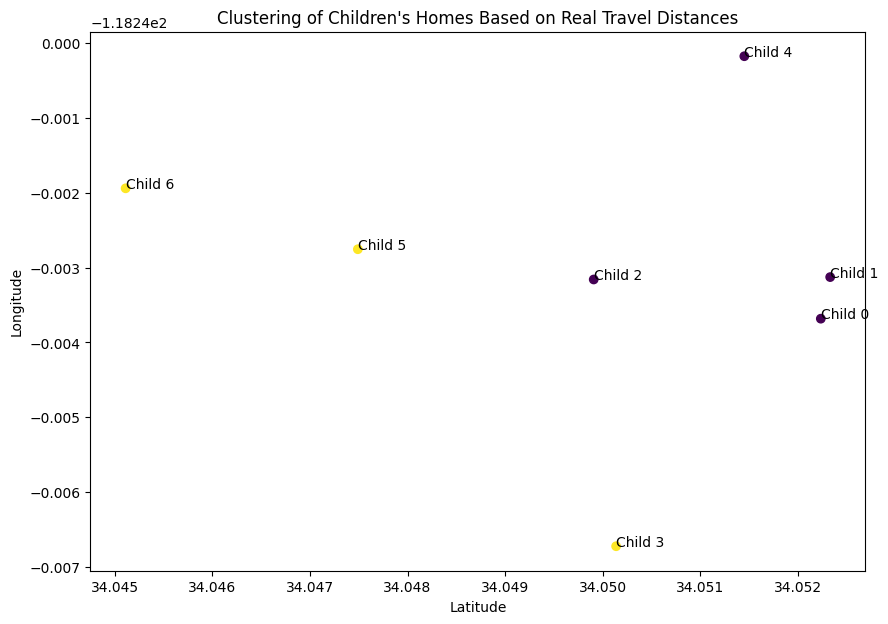

In [12]:
import matplotlib.pyplot as plt

# Scatter plot of the locations, color-coded by cluster labels
latitude = [loc[0] for loc in locations]
longitude = [loc[1] for loc in locations]

plt.figure(figsize=(10, 7))
plt.scatter(latitude, longitude, c=labels, cmap='viridis', marker='o')

# Annotate each point with the child's index
for i, (lat, lon) in enumerate(locations):
    plt.annotate(f"Child {i}", (lat, lon))

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Clustering of Children\'s Homes Based on Real Travel Distances')
plt.show()


In [13]:
import folium

# Create a folium map centered around the average location
avg_lat = np.mean([loc[0] for loc in locations])
avg_lon = np.mean([loc[1] for loc in locations])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)

# Define colors for different clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Add points to the map
for i, (lat, lon) in enumerate(locations):
    folium.Marker(
    location=[lat, lon],
    popup=f'Child {i} - Group {labels[i]}',
    icon=folium.Icon(color=colors[labels[i] % len(colors)])
    ).add_to(m)

# Save map to an HTML file
m.save('children_homes_clusters.html')

# Display the map
m
